In [60]:
import json
import math
import os
import urllib.request
import warnings
from urllib.error import HTTPError
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # 데이터 시각화 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # 최적화 알고리즘이 들어있음
import torch.utils.data as data
import torchvision # 컴퓨터 비전을 위한 데이테셋, 모델, 변환을 포함하는 라이브러리
# 컴퓨터 비전은 컴퓨터가 디지털 이미지나 영상을 인식하고 이해하는데 사용되는 기술 분야
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

In [61]:
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# "PATH_DATASETS"라는 환경변수의 값을 가져와 gh에 저장, "PaTH_DATASETS"라는 환경변수가 없다면 data/를 gh에 할당
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/Activation_Functions/" )

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


set_seed(42)

torch.backends.cudnn.deterministic = True # 효율성을 위해 확률적으로 작동
torch.backends.cudnn.benchmark = False # 입력 데이터의 크기가 변경되지 않을 때 커널의 실행 시간을 측정하고 가장 빠른 커널을 선택하는 기능

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [62]:
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
pretrained_files = [
    "FashionMNIST_elu.config",
    "FashionMNIST_elu.tar",
    "FashionMNIST_leakyrelu.config",
    "FashionMNIST_leakyrelu.tar",
    "FashionMNIST_relu.config",
    "FashionMNIST_relu.tar",
    "FashionMNIST_sigmoid.config",
    "FashionMNIST_sigmoid.tar",
    "FashionMNIST_swish.config",
    "FashionMNIST_swish.tar",
    "FashionMNIST_tanh.config",
    "FashionMNIST_tanh.tar",
]
os.makedirs(CHECKPOINT_PATH, exist_ok=True) # CHECKPOINT_PATH에 지정된 경로에 디렉토리 생성, exist_ok =True -> 디렉토리가 이미 존재해도 괜찮

for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name) # 변수 두개를 결합해 새로운 파일 경로를 만드는 명령어
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path) # 첫 번째 인자로 주어진 URL에서 데이터 검색, 두 번째 인자로 주어진 위치에 파일을 저장
        except HTTPError as e:
            print("오류 발생, GDrive폴더에서 파일 다운 요망, 혹은 작성장에게 문의",e

            )

In [63]:
class ActivationFunction(nn.Module): # nn에서 모듈을 상속받아 하위 클래스의 이름을 출력하거나 매서드를 공통으로 쓰기 쉽게
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}
        

In [64]:
class Sigmoid(ActivationFunction): # 시그모이드 함수
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

class Tanh(ActivationFunction): # hyperbolic tnagent
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)
    

In [65]:
s = Sigmoid()
print(s.config['name'])

Sigmoid


In [66]:
class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()

class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha
    
    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x >0, x, torch.exp(x) - 1)

class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [67]:
act_fn_by_name = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish}

# 각종 활성화 함수를 하나로 묶음

In [68]:
act_fn_by_name

{'sigmoid': __main__.Sigmoid,
 'tanh': __main__.Tanh,
 'relu': __main__.ReLU,
 'leakyrelu': __main__.LeakyReLU,
 'elu': __main__.ELU,
 'swish': __main__.Swish}

In [69]:
def get_grads(act_fn, x):
    x = x.clone().requires_grad_()
    # x.clone()은 x의 복사본을 반환
    # requires_grad_() 그래디언트 계산이 필요하다는 것을 pytorch에 알려준다 
    out = act_fn(x)
    out.sum().backward()
    return x.grad


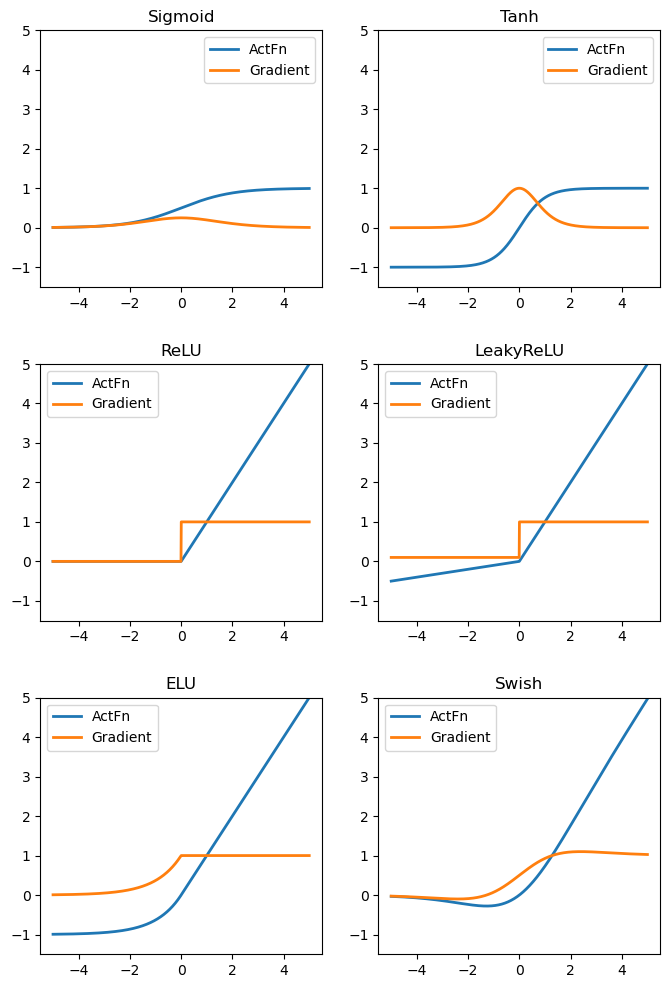

In [70]:
def vis_act_fn(act_fn, ax, x):
    y = act_fn(x) # 활성화 함수 실행
    y_grads = get_grads(act_fn, x) 
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy() # 시각화를 위해 cpu에 푸쉬
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())
# 그래디언트를 시각화 하기 위한 함수

act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
# 활성화 함수의 값을 업그레이드
x = torch.linspace(-5, 5, 1000) # 시각화 하길 원하는 범위
cols = 2
rows = math.ceil(len(act_fns) / float(cols))
fig, ax = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i, cols)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

In [71]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        # input_size: 입력이미지의 픽셀 사이즈
        # num_classes: 예측하길 원하는 클래스 숫자
        # 신경망에서 은닉층의 수
        super().__init__()
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        layer_size_last = layer_sizes[0]
        for layer_size in layer_sizes[1:]:
            layers += [nn.Linear(layer_size_last, layer_size), act_fn]
            layer_size_last = layer_size
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers)
        # 단일 모듈로 요약, 순서 적용
        self.config = {
            "act_fn":act_fn.config,
            "input_size": input_size,
            "unm_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }
        # 모듈을 로드하거나 저장하기 위해 하이퍼파라미터를 dictinoary 형태로 저장
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # 이미지를 평면백터로 재정의
        out = self.layers(x)
        return out

In [72]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None): # 디스크에 저장하기 위한 모델
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(
        config_file
    ), f'config파일을 찾을 수 없음 "{config_file}". 경로가 여기가 맞나요?, 여기다가 모델 정보를 저장한게 확실한가요?'

    assert os.path.isfile(
        model_file
    ), f'model_file을 찾을 수가 없습니다"{model_file}". 경로가 맞는지 제대로 모델 정보를 저장했는지 확인하세요' 

    with open(config_file) as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net

def save_model(model, model_path, model_name): 
    # model: 파라미터를 저장할 네트워크 객체
    # model_path: 체크포인트 경로
    # model_name; 모델의 이름
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), 
    _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)
    

        

In [73]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# 각각의 이미지를 텐서로 만든다, 정규화도 함
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
# fashinMNIST 데이터를 받는다.
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
# trian 데이터랑, 평가 데이터로 나눈다
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)
# 받은걸 로딩

In [74]:
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)
# 각 데이터로드된걸 쓰기 편하게 이름을 붙여서 저장

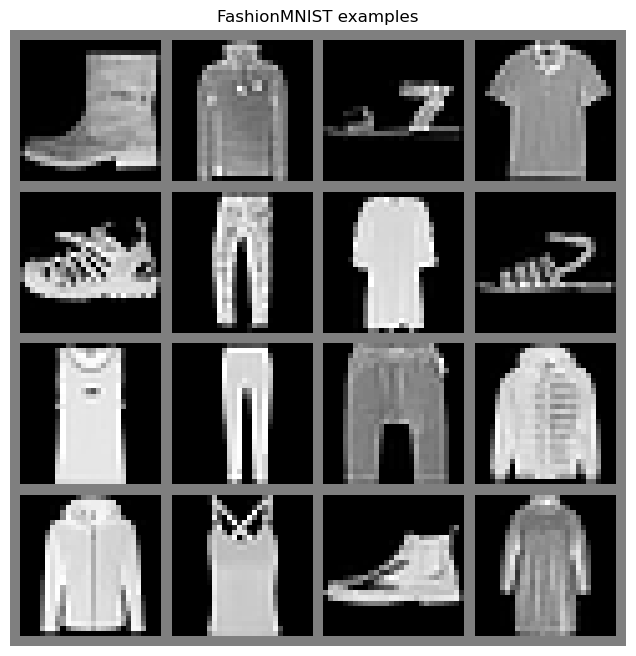

In [75]:
exmp_imgs = [train_set[i][0] for i in range(16)]
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0) # 텐서의 형태를 바꾸는 함수
# 더 나은 시각화를 위해 그리드로 구성

plt.figure(figsize=(8, 8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [76]:
x = torch.randn(2, 3, 5)
print(x)
print(x.size())
print(torch.permute(x, (1, 0, 2)))
print(torch.permute(x, (1, 0, 2)).size())

tensor([[[ 1.3902, -0.9516, -0.3317, -0.0311, -0.3839],
         [-1.2325,  0.6049,  0.1387,  0.4357,  0.0524],
         [-0.6388,  1.3148, -1.8483,  1.8257, -0.6374]],

        [[-2.1746, -0.3003, -1.3128,  0.5599, -0.5757],
         [ 1.0507,  0.7505,  1.2704, -0.8552,  0.5309],
         [-0.4714,  0.8987, -0.6248,  0.5909, -0.4287]]])
torch.Size([2, 3, 5])
tensor([[[ 1.3902, -0.9516, -0.3317, -0.0311, -0.3839],
         [-2.1746, -0.3003, -1.3128,  0.5599, -0.5757]],

        [[-1.2325,  0.6049,  0.1387,  0.4357,  0.0524],
         [ 1.0507,  0.7505,  1.2704, -0.8552,  0.5309]],

        [[-0.6388,  1.3148, -1.8483,  1.8257, -0.6374],
         [-0.4714,  0.8987, -0.6248,  0.5909, -0.4287]]])
torch.Size([3, 2, 5])


In [77]:
# 활성화 함수가 어떻게 그래디언트에 영향을 끼치는지 알아봅시다
def visualize_gradients(net, color="C0"):
    # net: 베이스네트워크의 클래스 객체
    # color: 히스토그램에서 시각화 하길 원하는 색 ( 활성화 함수 쉽게 볼려고 하는 거)
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # 한개의 배치를 네트워크에 통과 시켜 가중치의 그래디언트를 계산

    grads = {
        name: params.grad.data.view(-1).cpu().clone().numpy()
        for name, params in net.named_parameters()
        if "weight" in name
    }
    net.zero_grad()

   
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index % columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("grad magnitude")
        fig_index += 1
    fig.suptitle(
        f" gradient magnitude for activation function {net.config['act_fn']['name']}",fontsize=14, y=1.05
    )
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

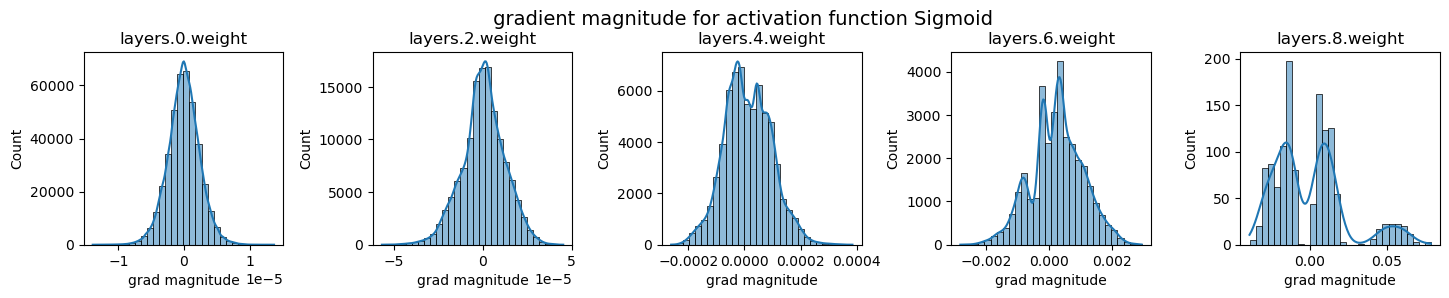

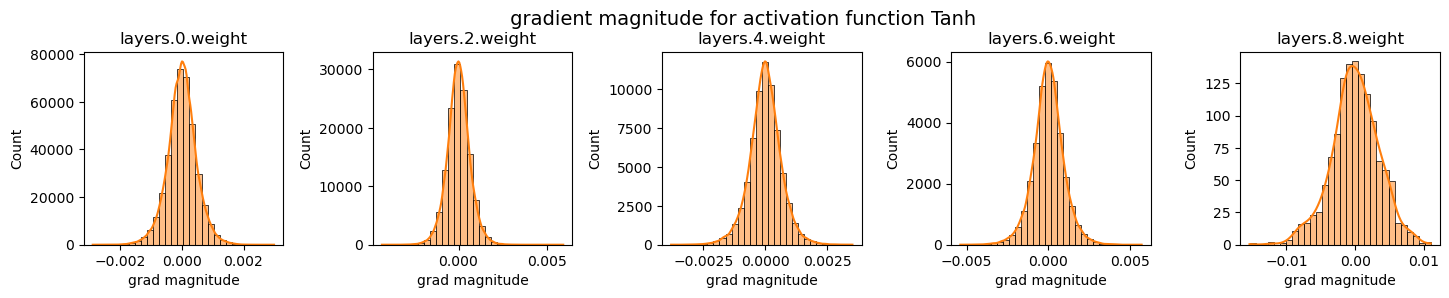

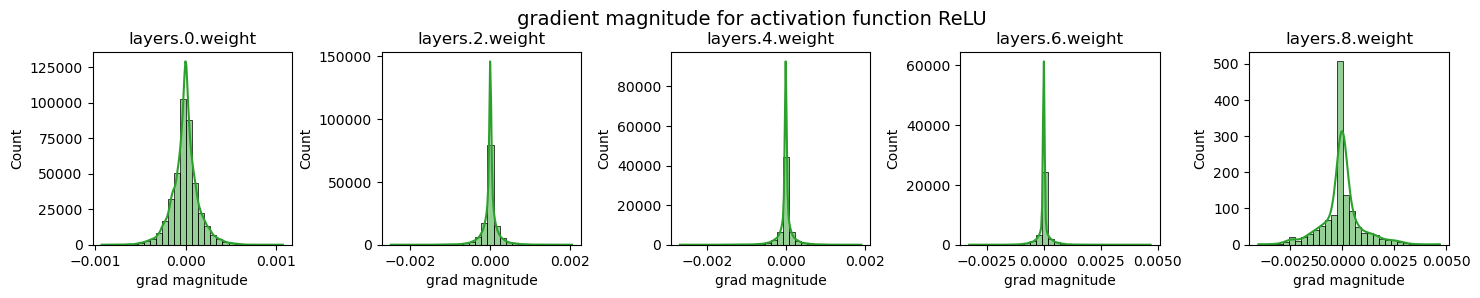

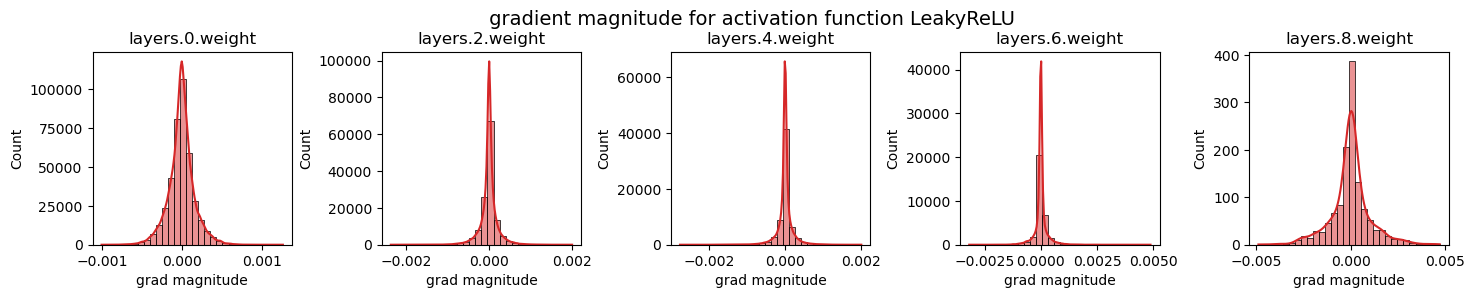

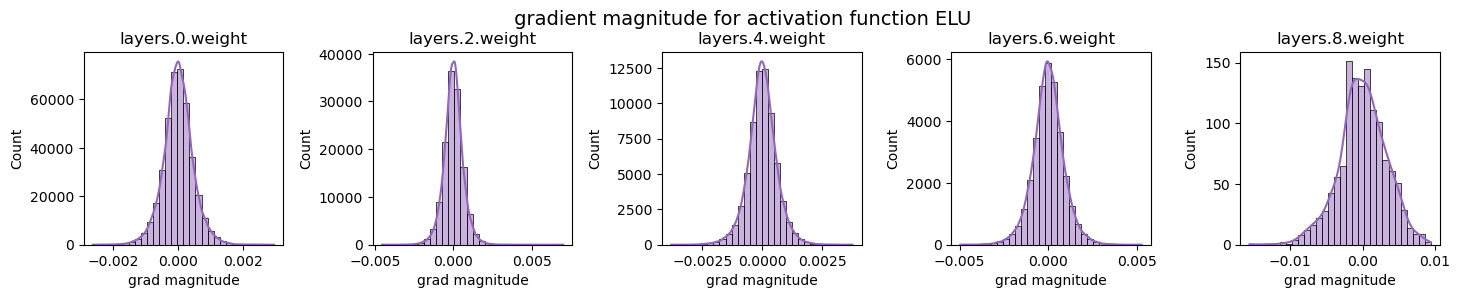

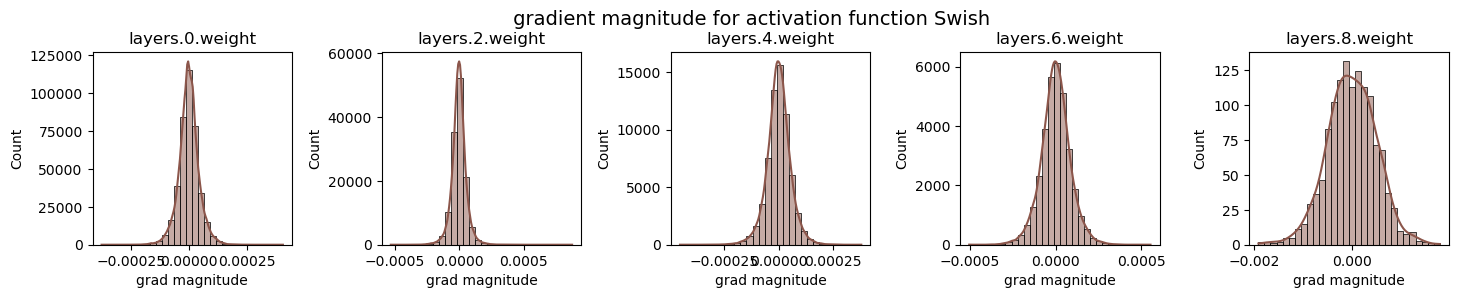

In [78]:
warnings.filterwarnings("ignore")
# 경고, 히스토 그램이 작은 값을 가질 시, 무시하겠음
for i, act_fn_name in enumerate(act_fn_by_name):
    # 모든 활성화 함수를 그래프화
    set_seed(42) # 재현성을 위해 
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")


In [79]:
# 훈련시킬 거임, 평가도 할거임,에폭 돌리고 최고의 모델을 뽑은 후에

def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    # FashionMNIST의 트레이닝 모델
    # net: 베이스 네트워크 객체
    # model_name: 모델 이름, 체크포인트 이름을 만들 때 사용한
    # max_epochs: 얼마나 돌릴건지
    # patience: 평가가 중요하지 않다고 판단되면 그냥 훈련을 빨리 끝내겠음
    # batch_size: 트레이닝에 사용할 베치 사이즈
    # overwrite: 결정, 사레를 어떻게 다룰건지, 체크포인트가 존재하면, ture면 덮어쓰기, false면 훈련 스킵

    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("모델 파일이 이미 존재하니깐 훈련 스킵할게요")
    else:
        if file_exists:
            print("모델 파일이 존재하는데 덮어쓸게")
    
        optimizer =optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
        # 최적화 정의 소실과 데이터 로드에 대해
        loss_module =nn.CrossEntropyLoss()
        train_loader_local =data.DataLoader(
            train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True
        )

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs): # 훈련
            net.train()
            true_preds, count =0.0, 0
            for imgs, lavels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) # gpu로 넣어줌
                optimizer.zero_grad() # 손실 역전파 실행전에만 초기화 시켜주면 됨
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            # 평가
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(
                f"[Epoch{epoch+1:2i}] 훈련 정확도: {train_acc*100.0:0:05.2f}%, Validataion accuracy: {val_acc*100.0:0:05.2f}%"
            )

            if len(val_scores) == 1 or val_acc > val_acc > val_scores[best_val_epoch]:
                print("\t (best 모델 저장중)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch =epoch
            elif best_val_epoch <= epoch - patience:
                print(f"{patience}에 비해 에폭을 돌려도 성능이 안좋아지므로 조기 종료함 ")
                break
        
        # 검증 정확도 곡선
        plt.plot([i for i in range(1, len(val_scores) + 1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()
    
    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f"Test accuracy: {test_acc*100.0:4.2f}%").center(50, "=") + "\n")
    return test_acc

def test_model(net, data_loader):
    # net: 베이스 네트워크의 트레인 모델
    # data_loader: 검증 또는 테스트 데이터 셋의 데이터 로드 객체

    net.eval()
    true_preds, count = 0.0, 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc



    


In [80]:
# 각 활성화 함수로 훈련 돌려봅시다
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

Training BaseNetwork with sigmoid activation...
모델 파일이 이미 존재하니깐 훈련 스킵할게요
==============Test accuracy: 10.00%===============

Training BaseNetwork with tanh activation...
모델 파일이 이미 존재하니깐 훈련 스킵할게요
==============Test accuracy: 87.59%===============

Training BaseNetwork with relu activation...
모델 파일이 이미 존재하니깐 훈련 스킵할게요
==============Test accuracy: 88.62%===============

Training BaseNetwork with leakyrelu activation...
모델 파일이 이미 존재하니깐 훈련 스킵할게요
==============Test accuracy: 88.92%===============

Training BaseNetwork with elu activation...
모델 파일이 이미 존재하니깐 훈련 스킵할게요
==============Test accuracy: 87.27%===============

Training BaseNetwork with swish activation...
모델 파일이 이미 존재하니깐 훈련 스킵할게요
==============Test accuracy: 88.73%===============



In [81]:
# 활성화 함수의 히스토그램을 그려서 실제 모델에서 활성화 된 값들을 봐보자
def visualize_activations(net, color="C0"):
    activations = {}

    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        for layer_index, layer in enumerate(net.layers[:-1]): #모든 활성화를 저장하기 위한 반복문
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()

    # 그림그리기
    columns = 4
    rows = math.ceil(len(activations) / columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns * 2.7, rows * 2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index // columns][fig_index % columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

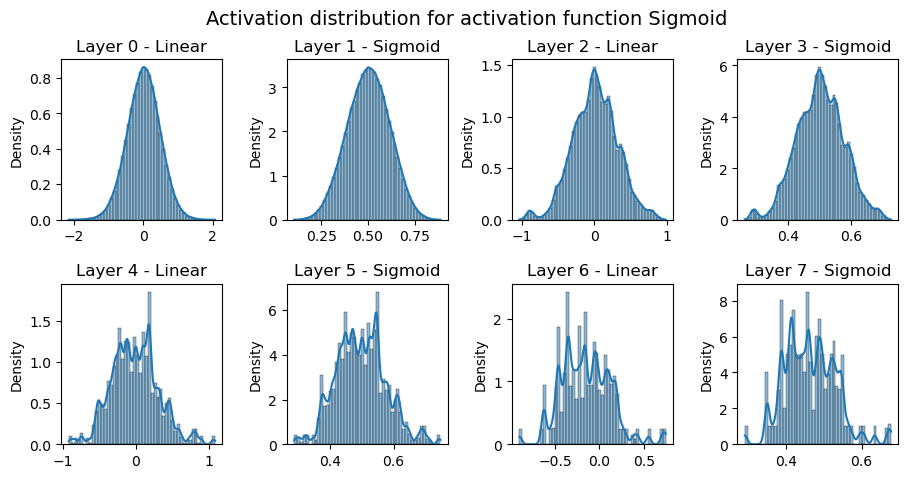

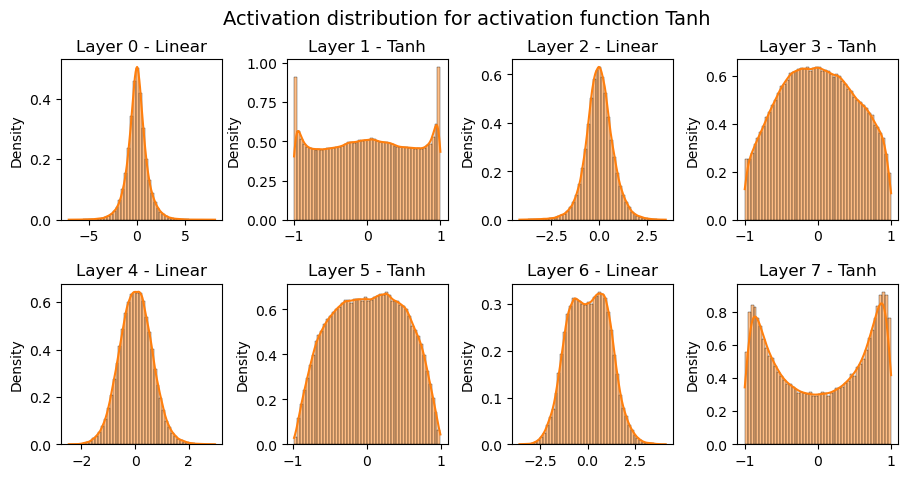

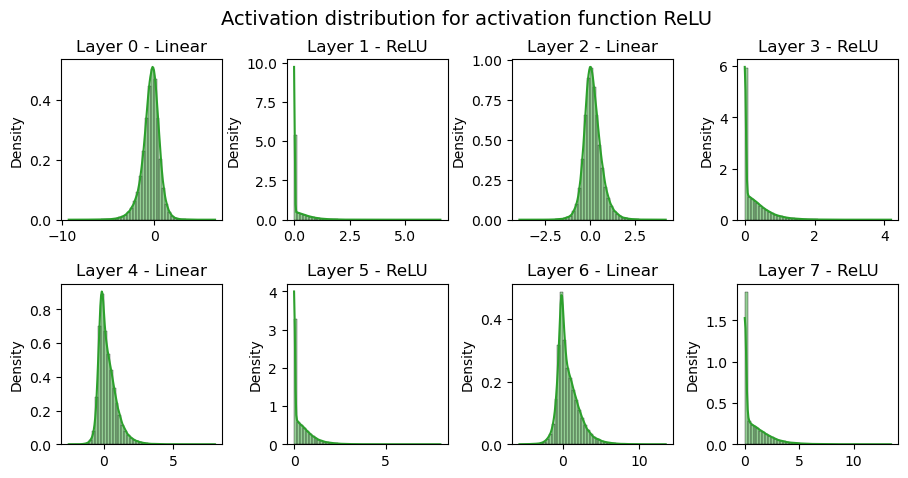

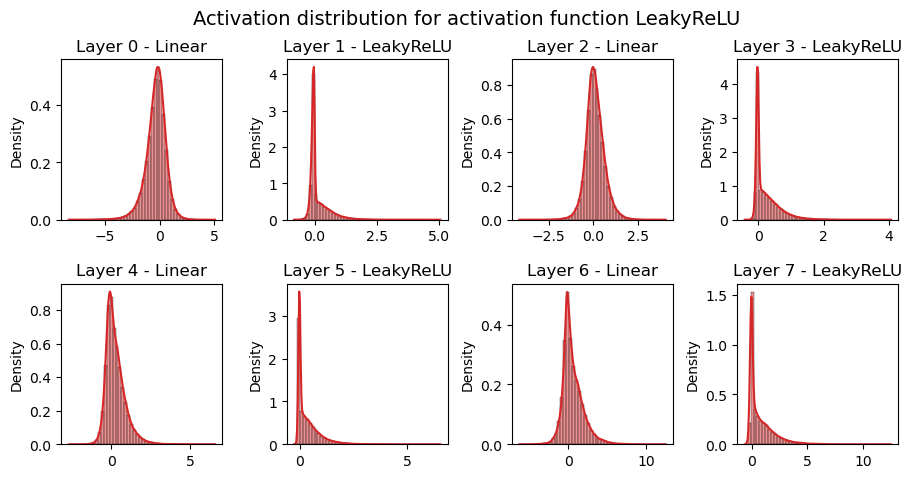

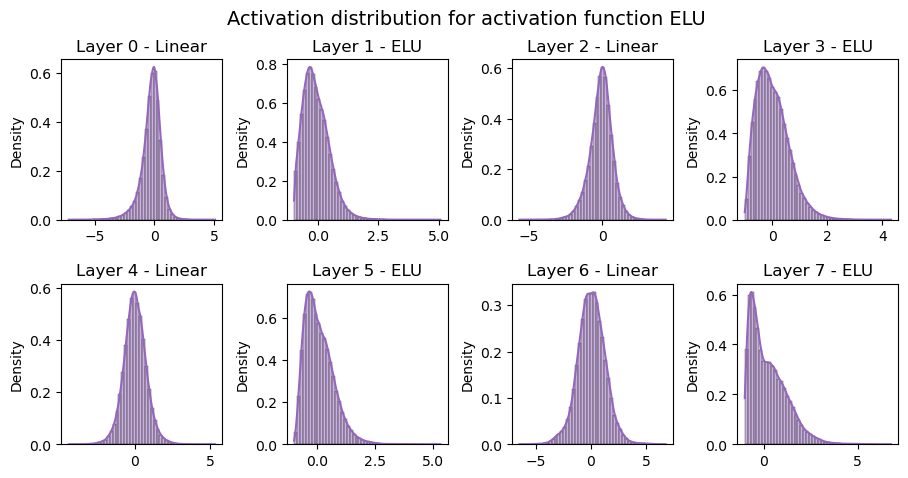

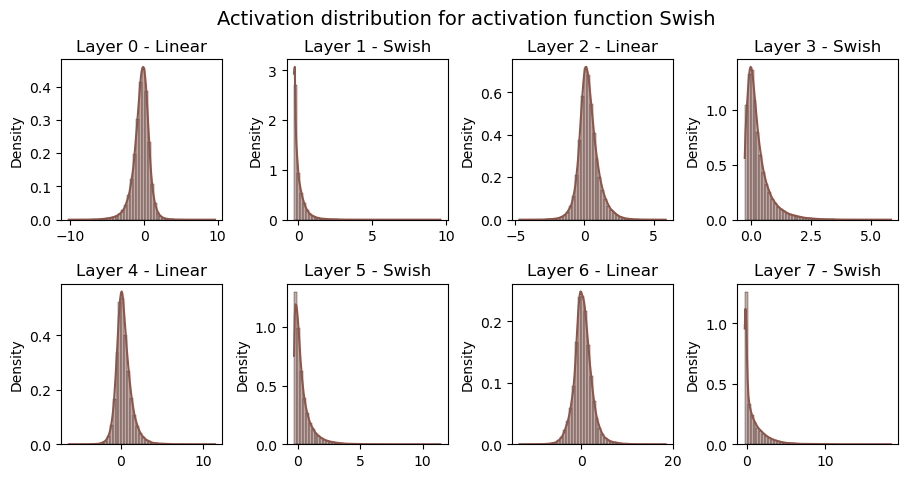

In [82]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")

In [83]:
# ReLU 네트워크에서 죽은 뉴런 찾기, 모든 데이터 포인트에 대해 뉴런이 정확히 0인지 여부를 기록함으로써

@torch.no_grad()
def measure_number_dead_neurons(net): # 죽은 뉴런을 찾기 위한 함수
    # 불리언 값을 초기에 1로 두고 활성화 값이 0이 아닐 때 변수에 0을 넣음, 그럼 죽은 뉴런은 1이 됨

    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool)
        for layer in net.layers[:-1]
        if isinstance(layer, nn.Linear)
    ]  

    net.eval()
    for imgs, labels in tqdm(train_loader, leave=False):  # Run through whole training set
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        for layer in net.layers[:-1]:
            imgs = layer(imgs)
            if isinstance(layer, ActivationFunction):
                neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("죽은 뉴런의 수:", number_neurons_dead)
    print(
        "퍼센트:",
        ", ".join(
            [f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]
        ),
    )

In [84]:
# 훈련 안된 죽은 뉴런의 수 측정
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

죽은 뉴런의 수: [0, 0, 3, 10]
퍼센트: 0.00%, 0.00%, 1.17%, 7.81%


In [85]:
# 훈련된 네트워크
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

죽은 뉴런의 수: [0, 0, 0, 3]
퍼센트: 0.00%, 0.00%, 0.00%, 2.34%


In [86]:
# 죽은 뉴런이 레이어 층이 깊어짐에 따라 어떻게 행동하는지 보자
set_seed(42)
net_relu = BaseNetwork(
    act_fn=ReLU(),
    hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128],
).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

죽은 뉴런의 수: [0, 0, 7, 27, 89, 60, 58, 61, 72, 56]
퍼센트: 0.00%, 0.00%, 2.73%, 10.55%, 34.77%, 46.88%, 45.31%, 47.66%, 56.25%, 43.75%
